<a href="https://colab.research.google.com/github/AadeshVarude/Auto-Pano/blob/main/Panorama_stich.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary librarires and images for the panorama**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import imshow
import math
import imutils
import os
import sklearn.cluster
import os
from skimage.feature import peak_local_max

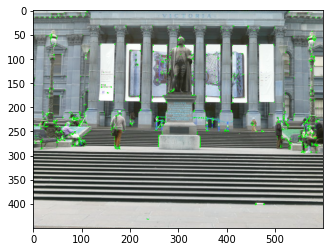

In [ ]:
img_1= cv2.imread("/content/1.jpg")
img1= cv2.imread("/content/1.jpg")
gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
# print(type(gray_1))
cv2.GaussianBlur(gray_1,(3,3),0)
gray = np.float32(gray_1)
dst_1 = cv2.cornerHarris(gray,2,3,0.04)
# print(dst_1.shape)
img_1[dst_1>0.01*dst_1.max()]=[0,255,0]
dst_1[dst_1<0.001*dst_1.max()]=0
plt.imshow(img_1)



img_2= cv2.imread("/content/2.jpg")
img2= cv2.imread("/content/2.jpg")
gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
# print(type(gray_2))
cv2.GaussianBlur(gray_2,(3,3),0)
# plt.imshow(gray,cmap='gray')
gray = np.float32(gray_2)

dst_2 = cv2.cornerHarris(gray_2,2,3,0.04)
# print(dst_2.shape)
img_2[dst_2>0.01*dst_2.max()]=[0,255,0]
dst_2[dst_2<0.01*dst_2.max()]=0
plt.imshow(img_2)

In [ ]:
print(dst_2)
local_max=peak_local_max(dst_2,min_distance=15)
print(local_max[0])
img_2[local_max[0,0],local_max[0,1]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[188 220]


array([  0, 255,   0], dtype=uint8)

#Code for  Adaptive Non-Maximal Suppression (ANMS), This algorithm will find best corners for you

In [ ]:
def ANMS(img,c_img,Nbest):
  local_max=peak_local_max(c_img,min_distance=15)
  r=np.zeros(local_max.shape[0])
  ed=0
  x=np.zeros((local_max.shape[0],1))
  y=np.zeros((local_max.shape[0],1))
  for i in range(len(r)):
    r[i]=np.inf
  for i in range(local_max.shape[0]):
    for j in range(local_max.shape[0]):
      x_j=local_max[j][0]
      y_j=local_max[j][1]

      x_i=local_max[i][0]
      y_i=local_max[i][1]
      if(c_img[x_j][y_j]>c_img[x_i][y_i]):
        ed=(x_j-x_i)*(x_j-x_i)+(y_j-y_i)*(y_j-y_i)
      if(ed<r[i]):
        r[i]=ed
        x[i]=x_j
        y[i]=y_j
  if local_max.shape[0] < Nbest:
    Nbest = local_max.shape[0]
  r= np.argsort(r)
  r = np.flip(r)
  r = r[0:Nbest]
  x_best=np.zeros((Nbest,1))
  y_best=np.zeros((Nbest,1))
  for i in range(Nbest):
    x_best[i] = int(y[r[i]])
    y_best[i] = int(x[r[i]])
    a=x_best[i]
    b=y_best[i]
    cv2.circle(img,(int(a[0]), int(b[0])) , 5, (0, 0, 255), -1)
  plt.imshow(img)
  return x_best,y_best

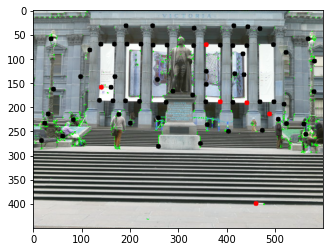

In [ ]:
x2,y2=ANMS(img_2,dst_2,100)


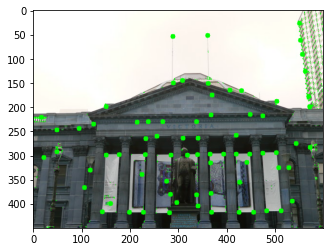

In [ ]:
x1,y1=ANMS(img_1,dst_1,300)


Function to calculate the feature descriptors considering the image patch size as 40

In [ ]:
def cal_feature_descriptor(gray_img,x_corner_cor,y_corner_cor,patch_size):
  x_cor=int(x_corner_cor)#pixel cordinates
  y_cor=int(y_corner_cor)
  g_img=gray_img
  p=int(patch_size)
  patch=g_img[x_cor:x_cor+p,y_cor:y_cor+p]
  # print(patch)
  patch=cv2.GaussianBlur(patch,(3,3),0)
  patch=cv2.resize(patch, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)
  feat=patch.reshape(-1)
  feat = (feat-feat.mean())/ np.std(feat)
  return feat

**Best matched features**

In [ ]:
gray_i1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
gray_i2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
# print(gray_i1.shape)
gray_img_1=np.pad(gray_i1,40,mode='edge')
gray_img_2=np.pad(gray_i2,40,mode='edge')
# print(gray_img_1.shape)
corners_1= np.concatenate((x1, y1), axis = 1)
corners_2= np.concatenate((x2, y2), axis = 1)
# print(corners_1)
patch_size=40
descriptors_1=[]
descriptors_2=[]
best_match_c1=[]
best_match_c2=[]
for corner in corners_1:
  # print(corner)
  a1=cal_feature_descriptor(gray_img_1,corner[1],corner[0],patch_size=40)
  descriptors_1.append(a1)
for corner in corners_2:
 a2=cal_feature_descriptor(gray_img_2,corner[1],corner[0],patch_size=40)
 descriptors_2.append(a2)
best_match_pair=[]

# print(len(descriptors_1))
# print(len(descriptors_2))
count=0
for i,descriptor_1 in enumerate(descriptors_1):
  god_feat=[]
  count=0
  # print(type(descriptor_1))
  for j,descriptor_2 in enumerate(descriptors_2):
    count=count+1
    # print(type(descriptor_2))
    god_feat.append(np.sum((descriptor_1-descriptor_2)**2))
  best_match_loc=np.argmin(god_feat)
  best_match_pair.append([corners_1[i],corners_2[best_match_loc]])
  # print(count)

# best_match_pair

**Plotting the matches for images**


In [ ]:
def plotMatch(img, best_match_pair,w1):
  imgNew= np.copy(img)
  for pair in best_match_pair:
    mc_1=pair[0]
    mc_2=pair[1]
    cv2.line(imgNew,(int(mc_1[0]),int(mc_1[1])),(int(mc_2[0])+w1,int(mc_2[1])),[0,255,0],1)
  plt.imshow(imgNew)
  return

In [ ]:
h1,w1,_ = img_1.shape
h2,w2,_ = img_2.shape
new = np.zeros((max(h1,h2),w1+w2,3),dtype='uint8')
new[:h1, :w1,:] = img_1
new[:h2, w1:,:] = img_2

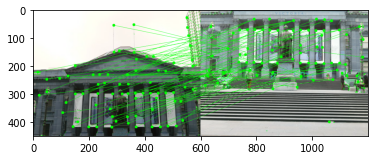

In [ ]:
a=best_match_pair
a=np.array(best_match_pair)
plotMatch(new, a,w1)
# a[:,1]


#Code for RANSAC : to reject the outliers in the feature matches

In [ ]:
def calculateError(set1, set2):
  E = np.zeros(set1.shape[0])
  tmp = set2 - set1
  num = set1.shape[0]

  for n in range(num):
    E[n] = np.linalg.norm(tmp[n])
  # print(E)
  return E

In [ ]:
# def ransac(best_match_pair):
N_best = 0
H_best = np.zeros([3, 3])
thresh=5
Nmax=5000
# set1 = a[:, 0]
mc_1=a[:, 0]
mc_2=a[:, 1]
# print(mc_1[:,0])
filtered_pair_indices = []
# print(img1_trans)
for i in range(Nmax):
  loc=mc_1.shape[0]
  select=np.random.choice(loc,size=4)
  # print(select)
  mc_1_rand=mc_1[select]
  mc_2_rand=mc_2[select]

  H=cv2.getPerspectiveTransform(np.float32(mc_1_rand), np.float32(mc_2_rand))
  set1_dash = np.vstack((mc_1[:,0], mc_1[:,1], np.ones([1, loc])))
  set1_transformed_dash = np.dot(H, set1_dash)
  # print(set1_transformed_dash.shape)
  t1 = set1_transformed_dash[0,:]/(set1_transformed_dash[2,:] + 1e-10)
  t2 = set1_transformed_dash[1,:]/(set1_transformed_dash[2,:] + 1e-10)
  set1_transformed = np.array([t1, t2]).T
  # print(set1_transformed.shape)
  # print(mc_2.shape)
  E = calculateError(mc_2, set1_transformed)
  E[E <= thresh] = 1
  E[E > thresh] = 0


  N = np.sum(E)
  # print(N)


  if N > N_best:
    N_best = N
    H_best = H
    filtered_pair_indices = np.where(E == 1)

filtered_set1 =  mc_1[filtered_pair_indices]
filtered_set2 =  mc_2[filtered_pair_indices]

print("Number of pairs after filtering = ", filtered_set1.shape[0])

filter_matched_pairs = np.zeros([filtered_set1.shape[0], filtered_set1.shape[1], 2])

filter_matched_pairs[:, 0, :] = filtered_set1
filter_matched_pairs[:, 1, :] = filtered_set2

filter_matched_pairs = filter_matched_pairs.astype(int)
print(filter_matched_pairs)

Number of pairs after filtering =  48
[[[426 417]
  [413 190]]

 [[366 297]
  [358  71]]

 [[426 417]
  [413 190]]

 [[228 417]
  [220 188]]

 [[143 416]
  [137 186]]

 [[394 297]
  [387  72]]

 [[456 417]
  [442 191]]

 [[426 417]
  [413 190]]

 [[282 418]
  [275 190]]

 [[232 298]
  [223  70]]

 [[232 298]
  [223  70]]

 [[151 299]
  [140  70]]

 [[442 314]
  [434  90]]

 [[199 417]
  [191 187]]

 [[232 298]
  [223  70]]

 [[341 404]
  [330 175]]

 [[ 49 292]
  [ 37  59]]

 [[341 264]
  [333  37]]

 [[285 299]
  [277  72]]

 [[232 298]
  [223  70]]

 [[ 49 292]
  [ 37  59]]

 [[341 404]
  [330 175]]

 [[151 299]
  [140  70]]

 [[143 416]
  [137 186]]

 [[513 414]
  [498 189]]

 [[573 283]
  [569  59]]

 [[427 355]
  [417 131]]

 [[426 417]
  [413 190]]

 [[ 49 292]
  [ 37  59]]

 [[420 258]
  [415  32]]

 [[228 417]
  [220 188]]

 [[232 298]
  [223  70]]

 [[394 297]
  [387  72]]

 [[456 417]
  [442 191]]

 [[178 298]
  [168  70]]

 [[426 417]
  [413 190]]

 [[282 418]
  [275 190]]



In [ ]:
def plotMatch(img, best_match_pair,w1):
  imgNew= np.copy(img)
  for pair in best_match_pair:
    mc_1=pair[0]
    mc_2=pair[1]
    cv2.line(imgNew,(int(mc_1[0]),int(mc_1[1])),(int(mc_2[0]+w1),int(mc_2[1])),[0,255,0],1)
  plt.imshow(imgNew)
  return

[[ 1.14466754e+00  9.49734721e-02 -4.53147479e+01]
 [ 2.31847484e-02  1.17282626e+00 -2.76860839e+02]
 [ 4.15920916e-05  3.52099318e-04  1.00000000e+00]]


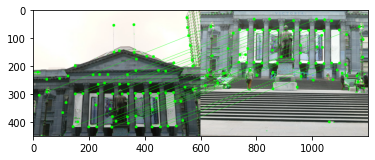

In [ ]:
plotMatch(new, filter_matched_pairs,w1)
print(H_best)

In [ ]:
def stitchImagePairs(img0, img1, H):
  image0 = img0.copy()
  image1 = img1.copy()

  #stitch image 0 on image 1
  print("shapes")
  print(image0.shape)
  print(image1.shape)


  h0 ,w0 ,_ = image0.shape
  h1 ,w1 ,_ = image1.shape

  points_on_image0 = np.float32([[0, 0], [0, h0], [w0, h0], [w0, 0]]).reshape(-1,1,2)
  points_on_image0_transformed = cv2.perspectiveTransform(points_on_image0, H)
  print("transformed points = ", points_on_image0_transformed)
  points_on_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1,1,2)

  points_on_merged_images = np.concatenate((points_on_image0_transformed, points_on_image1), axis = 0)
  points_on_merged_images_ = []

  for p in range(len(points_on_merged_images)):
    points_on_merged_images_.append(points_on_merged_images[p].ravel())

  points_on_merged_images_ = np.array(points_on_merged_images_)

  x_min, y_min = np.int0(np.min(points_on_merged_images_, axis = 0))
  x_max, y_max = np.int0(np.max(points_on_merged_images_, axis = 0))

  print("min, max")
  print(x_min, y_min)
  print(x_max, y_max)

  # overlap_area = cv2.polylines(image1,[np.int32(points_on_image0_transformed)],True,255,3, cv2.LINE_AA)
  # cv2.imshow("original_image_overlapping.jpg", overlap_area)
  # cv2.waitKey()
  # cv2.destroyAllWindows()
  H_translate = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]) # translate

  image0_transformed_and_stitched = cv2.warpPerspective(image0, np.dot(H_translate, H), (x_max-x_min, y_max-y_min))

  #image0_transformed_and_stitched[-y_min:-y_min+h1, -x_min: -x_min+w1] = image1

  images_stitched = image0_transformed_and_stitched.copy()
  images_stitched[-y_min:-y_min+h1, -x_min: -x_min+w1] = image1

  indices = np.where(image1 == [0,0,0])
  y = indices[0] + -y_min
  x = indices[1] + -x_min

  images_stitched[y,x] = image0_transformed_and_stitched[y,x]

  return images_stitched


In [ ]:
def cropImageRect(image):

  img = image.copy()
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  _,thresh = cv2.threshold(gray,5,255,cv2.THRESH_BINARY)
  kernel = np.ones((5,5), np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  x,y,w,h = cv2.boundingRect(contours[len(contours)-1])
  crop = img[y:y+h,x:x+w]

  return crop

#Plotting the stiching of two images#

shapes
(450, 600, 3)
(450, 600, 3)
transformed points =  [[[ -45.314747  -276.86084  ]]

 [[  -2.2242627  216.59297  ]]

 [[ 578.18475    223.7805   ]]

 [[ 625.8671    -256.54776  ]]]
min, max
-45 -276
625 450


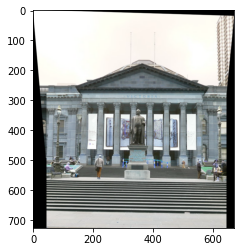

In [ ]:
stitched_image = stitchImagePairs(img1, img2, H_best)
stitched_image = cropImageRect(stitched_image)
plt.imshow(stitched_image)